# Data Preprocessing
Leon Yin

This notebook analyses the results of the element categorization and area estimations from the last notebook.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
import json
import time
import glob
import tempfile
import warnings
import inspect
from collections import Counter
from multiprocessing import Pool
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from bs4 import BeautifulSoup
from tqdm import tqdm
from IPython.display import display

sys.path.append("..")
from utils.config import (
    google_domains,
    cat2color,
    width
)

## Read the intermediates

In [3]:
# inputs
data_dir_metadata = '../data/intermediary/google_search/'
metadata_pattern = os.path.join(data_dir_metadata, 
                                'iPhone-X/*/*/*/*/json/parsed_meta.ndjson')
# output
fn_metadata = '../data/intermediary/element_metadata_15k.jsonl.gz'

In [4]:
metadata_files = glob.glob(metadata_pattern)
len(metadata_files)

15281

In [5]:
header = 160

In [6]:
def get_bottom(row):
    """Finds the bottom of the last element"""
    return row['location']['y'] + row['dimensions']['height']

In [7]:
def calc_area(location : dict,
              rect : dict,
              width : int = 1e6,
              height_top : int = 0,
              height_bottom : int = 1e6) -> float:
        """
        Given a `rect` from selenium, 
        (see the `rect` module from selenium elements)
        we're able to locate the coordinates of corners
        of a rectangular element and calculate the area.

        Set the `width` and `height` params to create boundries.
        `np.clip` will restrict the given `h` and `w` to
        the bounds of the screen.
        """
        x = location.get('x')
        
        # take care of neg values
        x = np.clip(x, a_min=0, a_max=1e6)
        y = location.get('y')
        h = rect.get('height')
        w = rect.get('width')

        # calculate the top left X coord, top right X coord
        tl_x = np.clip(x,     0, width)
        tr_x = np.clip(x + w, 0, width)
        # and the top right Y coord and bottom right Y coord
        tr_y = np.clip(y,     height_top, height_bottom)
        br_y = np.clip(y + h, height_top, height_bottom)

        # calculate the width and height (length) of the rectangle and the area.
        rect_w = tr_x - tl_x 
        rect_h = br_y - tr_y
        rect_a = rect_w * rect_h

        return rect_a

In [8]:
n_quantiles = 5

In [9]:
def read_file(fn):
    """A json reader, this function allows parallelization"""
    metadata = pd.read_json(fn, lines=True, 
                             orient='records')
    
    bottom_element = metadata.apply(get_bottom, 
                                    axis=1).max()
    metadata.loc[:, "position_last_element"] = bottom_element
    metadata.loc[:, "fn_metadata"] = fn
    
    # how long is each quartile?
    interval = (bottom_element - header) / n_quantiles

    # create boundaries for four equal-sized quartiles
    quartiles = {}
    for i in range(0, n_quantiles):
        upper = (i * interval) + header
        lower = ((i + 1) * interval) + header
        quartiles[f'q{i + 1}'] = {
            'upper_bound' : upper,
            'lower_bound' : lower
        }

    # calculate the area of each element in each of the quartiles.
    for k, v in quartiles.items():
        metadata.loc[:, f"{k}_area"] = metadata.apply(
            lambda row: calc_area(
                rect= row['dimensions'],
                location= row['location'],
                width= width,
                height_top= v['upper_bound'],
                height_bottom= v['lower_bound']
            ), axis=1
        )
        
    return metadata.to_dict(orient='records')

In [10]:
# how many cores to use when reading and processing files
n_processes = 12

data = []
with Pool(n_processes) as pool:
    for record in tqdm(pool.imap_unordered(read_file, 
                                           metadata_files), 
                       total=len(metadata_files)):
        data.extend(record)

100%|██████████| 15281/15281 [02:20<00:00, 108.51it/s]


In [11]:
df = pd.DataFrame(data)

In [12]:
df = df[[c for c in df.columns if c not in ['element', 'element_class']]]

In [13]:
print(json.dumps(df.iloc[-1].to_dict(), 
                 indent=2))

{
  "text": "How a Car Works \u203a basics \u203a how-a-...How a diesel engine works | How a Car WorksTraditionally, diesel engines have always been seen as noisy, smelly and underpowered engines of little use other than in trucks, taxis and\u00a0...",
  "link": "https://www.howacarworks.com/basics/how-a-diesel-engine-works",
  "domain": "howacarworks.com",
  "xpath": "/html/body/div[10]/div/div[6]/div/div[3]/div/div[7]/div[2]/div",
  "category": "organic-search_result_1a",
  "tag": "div",
  "attrs": {
    "class": [
      "mnr-c",
      "xpd",
      "O9g5cc",
      "uUPGi"
    ]
  },
  "dimensions": {
    "height": 197.0,
    "width": 422.0
  },
  "location": {
    "x": 8,
    "y": 4417
  },
  "area": 0.0,
  "area_page": 72299.0,
  "fn_input": "../data/input/google_search/iPhone-X/2020/01/02/Diesel-engine/html/webpage_raw.html",
  "position_last_element": 5481.0,
  "q1_area": 0.0,
  "q2_area": 0.0,
  "q3_area": 0.0,
  "q4_area": 0.0,
  "q5_area": 72299.0
}


In [14]:
def label_data(category : str):
    """Thae label is the first word of each category"""
    label = category.split('-')[0]
    return label

In [15]:
df['label'] = df.category.apply(label_data)

In [16]:
df.label.value_counts()

link       645679
answer     228590
organic    223239
amp         81450
ads          4568
Name: label, dtype: int64

In [17]:
len(df)

1183526

## Standardizing categories to be more human readible

In [18]:
cat2catstd = {
    'organic-search_result_1a' : 'organic-search_result',
    'organic-search_result_2a' : 'organic-search_result',
    'organic-search_result_2c': 'organic-search_result',
    'organic-search_result_1b' : 'organic-search_result',
    'organic-search_result_2b': 'organic-search_result',
    'amp-search_result_2' : 'amp-search_result',
    'amp-search_result_1' : 'amp-search_result',
    'organic-tweet_2 ': 'organic-tweet',
    'answer-expand_1' : 'answer-expand',
    'answer-expand_2' :'answer-expand',
    'answer-expand_3' :'answer-expand',
    'link-google_2' : 'link-google',
    'organic-tweet_2' : 'organic-tweet',
    'link-button_2' : 'link-button',
    'answer-knowledge_panel_answer_1' : 'answer-knowledge_panel_answer',
    'answer-knowledge_panel_answer_2' : 'answer-knowledge_panel_answer',
    'answer-date_2' : 'answer-date',
    'link-youtube_search_result_1a' : 'link-youtube_search_result',
    'link-youtube_search_result_2a' : 'link-youtube_search_result',
    'link-youtube_search_result_2b' : 'link-youtube_search_result',
    'link-flights_1' : 'link-flights',
    'link-google_map_2' : 'link-google_map'
}

In [19]:
df.category.replace(cat2catstd, 
                    inplace=True)

In [20]:
df.category.nunique()

66

In [21]:
link2subcat = {
    'link-site_search' : 'google-search',
    'link-movie_trailer' : 'google-video',
    'link-video_top_answer' : 'google-video',
    'link-local_google_maps_results' : 'google-maps',
    'link-google_map' : 'google-maps',
    'link-img_reverse' : 'google-images',
    'link-knowledge_panel_tab' : 'google-knowledge-panel-links',
    'link-knowledge_panel_title' : 'google-knowledge-panel-links',
    'link-youtube' : 'google-video'
}

In [22]:
def standardize_category(row):
    '''Logic to assign a standardized category'''
    category = row['category']
    label = row['label']
    
    if label == 'amp':
        subcat = category
    elif label == 'link':
        subcat = link2subcat.get(category, 'google-misc')
    elif label == 'answer':
        if 'expand' in category:
            subcat = 'google-expandable-answer'
        else:
            subcat = 'google-answer'
    elif label == 'organic':
        subcat = category if category != 'organic-tweet' else 'organic'
    if label in ['ads']:
        subcat = label
    return subcat

In [23]:
df['category_standard'] = df.apply(standardize_category, 
                                   axis=1)

In [24]:
# makethese google search
df.loc[(df.link.str[:9] == '/search?q') &
       (df.label == 'link'), 
       'category_standard'] = 'google-search'

In [25]:
df.to_json(fn_metadata, orient='records', 
           lines=True, compression='gzip')

In [27]:
lengths = df.drop_duplicates(subset='fn_input').position_last_element

In [29]:
lengths.describe()

count    15281.000000
mean      5013.609155
std       1039.281390
min        716.000000
25%       4264.000000
50%       4971.000000
75%       5716.000000
max       9056.000000
Name: position_last_element, dtype: float64

In [46]:
import matplotlib.pyplot as plt

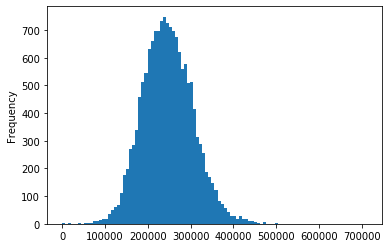

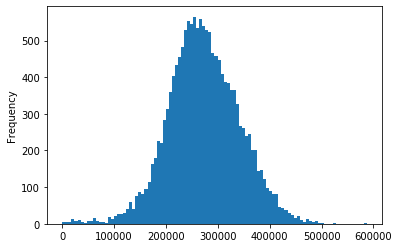

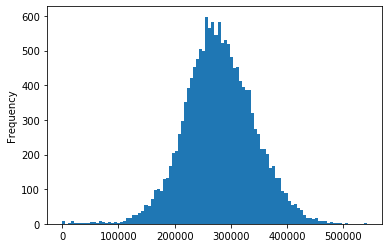

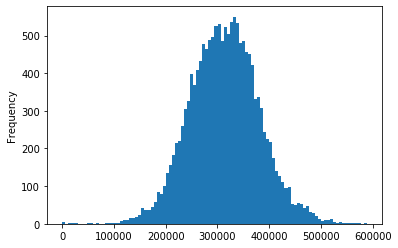

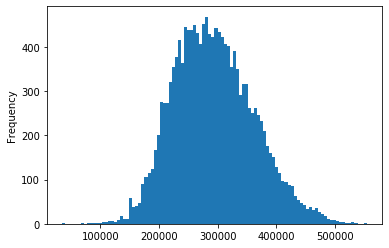

In [50]:
for col in ['q1_area', 'q2_area', 'q3_area', 'q4_area', 'q5_area']:
    df.groupby('fn_input')[col].sum().plot(kind='hist', bins=100)
    plt.show();